In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

# GitHub Link - https://github.com/also9275/Week4_NLP_Disaster_Tweets_Kaggle_Mini-Project

# 1. Brief description of the problem and data
This problem is about a problem of tweets classification into ones that have information about some disaster and all others. Solution of this problem is quite important as it helps people to use twitter as main communication channel in times of emergency

Data has train.csv and test.csv files.

train.csv file has this columns:
1. id
2. keyword
3. location
4. text
5. target

I will be using column 4 as Xs and column 5 as Ys

test.csv files has all the same columns except column 5. We will need to predict this column once model is ready

In [3]:
# Global constants that will be used in this notebook
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

In [4]:
# Download training and testing data
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [5]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 125MB/s]


In [6]:
import zipfile

# Unzip the archive
local_zip = '/content/nlp-getting-started.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

# 2. Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

In [7]:
# First let's see how data looks like
TRAIN_CSV = "/content/train.csv"

with open(TRAIN_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

id,keyword,location,text,target

First data point looks like this:

1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1

Second data point looks like this:

4,,,Forest fire near La Ronge Sask. Canada,1



In [8]:
def parse_data_from_file(filename):
    """
    Extracts tweets and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        tweets, labels (list of string, list of string): tuple containing lists
        of tweets and labels
    """

    tweets = []
    labels = []

    with open(filename, 'r') as csvfile:
      next(csvfile)
      reader = csv.reader(csvfile, delimiter=",")
      for row in reader:
        labels.append(int(row[-1]))
        tweets.append(row[-2])

    return tweets, labels

In [9]:
tweets, labels = parse_data_from_file(TRAIN_CSV)

print(f"dataset contains {len(tweets)} examples\n")

print(f"Text of second example:\n{tweets[1]}\n")
print(f"Text of fourth example:\n{tweets[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 7613 examples

Text of second example:
Forest fire near La Ronge Sask. Canada

Text of fourth example:
13,000 people receive #wildfires evacuation orders in California 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


(array([4342.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

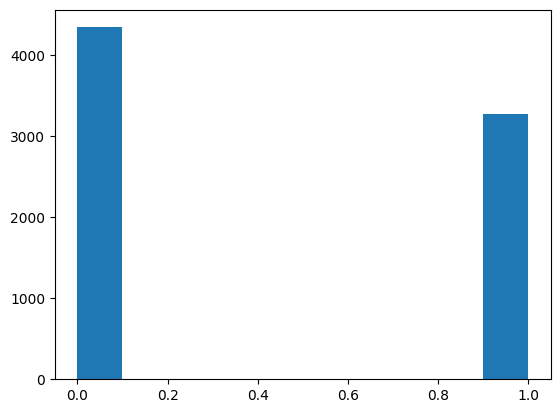

In [12]:
# Let's see distribution of classes
plt.hist(labels)

In [14]:
# Next we will need to split training data into training and validation sets
def train_val_split(tweets, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        tweets (list of string): lower-cased tweets without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to
        include in the train set

    Returns:
        train_tweets, validation_tweets, train_labels,
        validation_labels - lists containing the data splits
    """

    # Compute the number of tweets that will be used for training
    train_size = int(len(tweets) * training_split)

    # Split the tweets and labels into train/validation splits
    train_tweets = tweets[:train_size]
    train_labels = labels[:train_size]

    validation_tweets = tweets[train_size:]
    validation_labels = labels[train_size:]

    ### END CODE HERE

    return train_tweets, validation_tweets, train_labels, validation_labels

In [15]:
train_tweets, val_tweets, train_labels, val_labels = train_val_split(
    tweets, labels, TRAINING_SPLIT)

print(f"There are {len(train_tweets)} tweets for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_tweets)} tweets for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 6851 tweets for training.

There are 6851 labels for training.

There are 762 tweets for validation.

There are 762 labels for validation.


In [16]:
# To use text of tweets in our model we need to convert text to tokens
def fit_tokenizer(train_tweets, oov_token):
    """
    Instantiates the Tokenizer class on the training tweets

    Args:
        train_tweets (list of string): lower-cased tweets without stopwords to
        be used for training
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing
        the word-index dictionary
    """
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_tweets)

    return tokenizer

In [17]:
tokenizer = fit_tokenizer(train_tweets, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else
      "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' is {word_index['i']}")

Vocabulary contains 21099 words

<OOV> token included in vocabulary

index of word 'i' is 10


In [18]:
# and finally we need to make sure that all tweets have same length
def seq_pad_and_trunc(tweets, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token tweets and pads them to the same length

    Args:
        tweets (list of string): list of tweets to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence

    Returns:
        pad_trunc_tweets (array of int): tokenized tweets padded to the same length
    """
    tweets_seq = tokenizer.texts_to_sequences(tweets)

    # Pad the tweets using the correct padding, truncating and maxlen
    pad_trunc_tweets = pad_sequences(tweets_seq, maxlen=maxlen,
                                     padding=padding, truncating=truncating)


    return pad_trunc_tweets

In [19]:
train_pad_trunc_seq = seq_pad_and_trunc(train_tweets, tokenizer, PADDING,
                                        TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_tweets, tokenizer, PADDING,
                                      TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (6851, 16)

Padded and truncated validation sequences have shape: (762, 16)


In [20]:
# We also need to convert labels to np.arrays, so we can use it later in the model
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 3. Model Architecture
for a first iterartion I would like to try simple model that has Embedding layer on the top, then Bidirectional LSTM layer, following plain LSTM layer, then plain Dense layer and finally classifiction layer with sigmoid function

In [21]:
def create_model(vocab_size, embedding_dim, maxlen):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings

    Returns:
        model (tf.keras Model): the sentiment classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [22]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20,
                    validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
215/215 [==============================] - 23s 70ms/step - loss: 0.5087 - accuracy: 0.7592 - val_loss: 0.5102 - val_accuracy: 0.7546
Epoch 2/20
215/215 [==============================] - 4s 19ms/step - loss: 0.2688 - accuracy: 0.8988 - val_loss: 0.5258 - val_accuracy: 0.7402
Epoch 3/20
215/215 [==============================] - 4s 20ms/step - loss: 0.1402 - accuracy: 0.9530 - val_loss: 0.7382 - val_accuracy: 0.6824
Epoch 4/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0878 - accuracy: 0.9756 - val_loss: 0.6213 - val_accuracy: 0.7310
Epoch 5/20
215/215 [==============================] - 2s 10ms/step - loss: 0.0592 - accuracy: 0.9813 - val_loss: 1.1701 - val_accuracy: 0.7021
Epoch 6/20
215/215 [==============================] - 2s 10ms/step - loss: 0.0469 - accuracy: 0.9839 - val_loss: 1.1047 - val_accuracy: 0.7126
Epoch 7/20
215/215 [==============================] - 2s 9ms/step - loss: 0.0356 - accuracy: 0.9866 - val_loss: 1.3771 - val_accuracy: 0.6798

# 4. Results and Analysis
first let's try to visualize our loss function for train and validation sets.

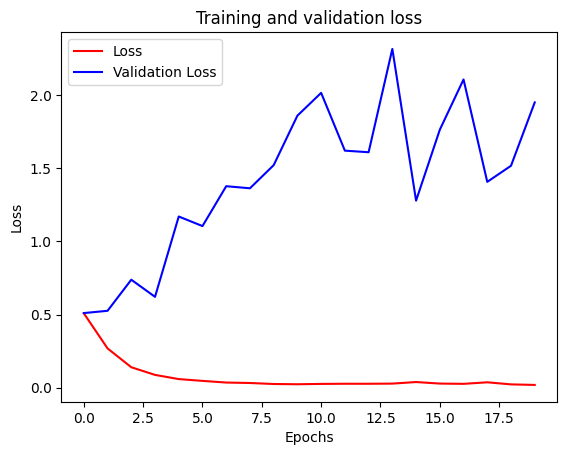

In [23]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# For me it looks like we are overfitting. Nevertheless, let's try to predict data and make a first submission to get the score

In [24]:
def parse_data_test_file(filename, oov_token, maxlen, padding, truncating):
    """
    Extracts twits and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        twits (ist of string)
    """

    tweets = []

    with open(filename, 'r') as csvfile:
      next(csvfile)
      reader = csv.reader(csvfile, delimiter=",")
      for row in reader:
        tweets.append(row[-2])


    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(tweets)


    tweets_seq = tokenizer.texts_to_sequences(tweets)
    pad_trunc_tweets = pad_sequences(tweets_seq, maxlen=maxlen,
                                     padding=padding, truncating=truncating)
    return pad_trunc_tweets

In [25]:
TEST_CSV = "/content/test.csv"
test_tweets = parse_data_test_file(TEST_CSV, OOV_TOKEN, MAXLEN, PADDING,
                                   TRUNCATING)

In [26]:
classes = model.predict(test_tweets)

102/102 [==============================] - 1s 4ms/step


In [27]:
output = open("submission.csv", "w")
output.write("id,target\n")
with open(TEST_CSV, 'r') as csvfile:
      next(csvfile)
      reader = csv.reader(csvfile, delimiter=",")
      for index, row in enumerate(reader):
        if float(classes[index]) > 0.5:
          class_res = 1
        else:
          class_res = 0
        output.write(f"{row[0]},{class_res}\n")
output.close()

In [28]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "First submission"

100% 22.2k/22.2k [00:00<00:00, 27.7kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

# Now let' try to update model to prevent overfitting. I think it makes sense to try to increate embedding size for Embedding layer and also decrease number of nodes in LSTM and Dense layers

In [29]:
def create_model_update(vocab_size, embedding_dim, maxlen):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings

    Returns:
        model (tf.keras Model): the sentiment classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 1000),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [30]:
model_update = create_model_update(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN)
history_update = model_update.fit(train_pad_trunc_seq, train_labels, epochs=20,
                    validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
215/215 [==============================] - 21s 74ms/step - loss: 0.5011 - accuracy: 0.7618 - val_loss: 0.4415 - val_accuracy: 0.8097
Epoch 2/20
215/215 [==============================] - 5s 22ms/step - loss: 0.2504 - accuracy: 0.9054 - val_loss: 0.5109 - val_accuracy: 0.7625
Epoch 3/20
215/215 [==============================] - 4s 19ms/step - loss: 0.1130 - accuracy: 0.9616 - val_loss: 0.8168 - val_accuracy: 0.7415
Epoch 4/20
215/215 [==============================] - 4s 18ms/step - loss: 0.0578 - accuracy: 0.9785 - val_loss: 0.8872 - val_accuracy: 0.7270
Epoch 5/20
215/215 [==============================] - 3s 16ms/step - loss: 0.0425 - accuracy: 0.9826 - val_loss: 0.9459 - val_accuracy: 0.7493
Epoch 6/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0280 - accuracy: 0.9885 - val_loss: 1.3222 - val_accuracy: 0.7362
Epoch 7/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0282 - accuracy: 0.9877 - val_loss: 1.1792 - val_accuracy: 0.721

In [31]:
classes = model.predict(test_tweets)
output = open("submission.csv", "w")
output.write("id,target\n")
with open(TEST_CSV, 'r') as csvfile:
      next(csvfile)
      reader = csv.reader(csvfile, delimiter=",")
      for index, row in enumerate(reader):
        if float(classes[index]) > 0.5:
          class_res = 1
        else:
          class_res = 0
        output.write(f"{row[0]},{class_res}\n")
output.close()

102/102 [==============================] - 0s 4ms/step


In [32]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Second submission"

100% 22.2k/22.2k [00:01<00:00, 21.4kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

# Now let's try to make our model even more simple by removing one of the LSTM layers

In [33]:
def create_model_update(vocab_size, embedding_dim, maxlen):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings

    Returns:
        model (tf.keras Model): the sentiment classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [34]:
model_update = create_model_update(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN)
history_update = model_update.fit(train_pad_trunc_seq, train_labels, epochs=20,
                    validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
215/215 [==============================] - 14s 50ms/step - loss: 0.5076 - accuracy: 0.7551 - val_loss: 0.4481 - val_accuracy: 0.7822
Epoch 2/20
215/215 [==============================] - 2s 11ms/step - loss: 0.2699 - accuracy: 0.8968 - val_loss: 0.4775 - val_accuracy: 0.7874
Epoch 3/20
215/215 [==============================] - 2s 11ms/step - loss: 0.1360 - accuracy: 0.9520 - val_loss: 0.6923 - val_accuracy: 0.7664
Epoch 4/20
215/215 [==============================] - 2s 10ms/step - loss: 0.0788 - accuracy: 0.9737 - val_loss: 0.7038 - val_accuracy: 0.7638
Epoch 5/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0514 - accuracy: 0.9826 - val_loss: 0.8755 - val_accuracy: 0.7454
Epoch 6/20
215/215 [==============================] - 2s 11ms/step - loss: 0.0367 - accuracy: 0.9857 - val_loss: 0.7704 - val_accuracy: 0.7520
Epoch 7/20
215/215 [==============================] - 2s 9ms/step - loss: 0.0267 - accuracy: 0.9870 - val_loss: 1.1859 - val_accuracy: 0.7349

In [35]:
classes = model_update.predict(test_tweets)
output = open("submission.csv", "w")
output.write("id,target\n")
with open(TEST_CSV, 'r') as csvfile:
      next(csvfile)
      reader = csv.reader(csvfile, delimiter=",")
      for index, row in enumerate(reader):
        if float(classes[index]) > 0.5:
          class_res = 1
        else:
          class_res = 0
        output.write(f"{row[0]},{class_res}\n")
output.close()

102/102 [==============================] - 1s 3ms/step


In [36]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Third submission"

100% 22.2k/22.2k [00:00<00:00, 25.5kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

# 5. Conclusion

On a third iteration I was able to improve score a little bit. More iteration is needed for this competition. Also it might be a great idea to try to add other columns into the model